# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'C:/Users/user/Desktop/ML marathon/data/Feature Engineering/'
df = pd.read_csv(data_path + 'titanic_train.csv')
train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier(random_state = 42)
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.244851
Ticket      0.157429
Fare        0.142186
Name        0.140019
Age         0.113819
Pclass      0.063274
Cabin       0.061059
Parch       0.029017
SibSp       0.026840
Embarked    0.021507
dtype: float64

#### 嘗試用 sklearn 的 [permutation_importance](https://scikit-learn.org/stable/modules/permutation_importance.html#misleading-values-on-strongly-correlated-features) 分析特徵重要性，得到相同的結果

In [4]:
from sklearn.inspection import permutation_importance
r = permutation_importance(estimator, df.values, train_Y,
                           n_repeats=30,
                           random_state=0)
pd.Series(data = r.importances_mean, index = df.columns).sort_values(ascending = False)

Sex         0.230640
Ticket      0.090011
Fare        0.084998
Pclass      0.080621
Name        0.067901
Age         0.067190
Cabin       0.033333
Embarked    0.015189
Parch       0.012907
SibSp       0.012383
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?
> 可能因為總特徵數僅有 10 個，在刪除一半重要性較低的特徵之後，生存率預估準確率下降。

In [5]:
# 高重要性特徵 + 隨機森林
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df[high_feature])
print(f'shape: {train_X.shape}')
print(f'score: {cross_val_score(estimator, train_X, train_Y, cv = 5).mean()}')

shape: (891, 5)
score: 0.8249199673592369


In [6]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
print(f'shape: {train_X.shape}')
print(f'score: {cross_val_score(estimator, train_X, train_Y, cv = 5).mean()}')

shape: (891, 10)
score: 0.826062394074446


# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?
> 將最高的兩個特徵 性別（Sex）和船票（Ticket）加、乘、除的組合之後，預測的準確率有些微提升！

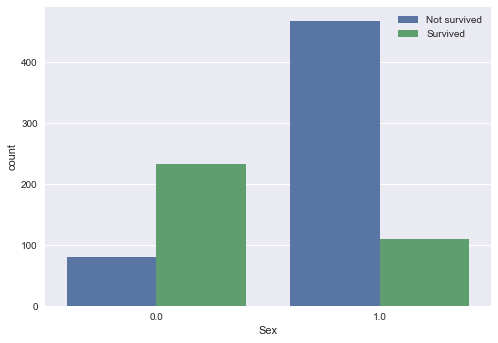

In [7]:
# 觀察重要特徵與目標的分布
# 重要性第一名的特徵是類別特徵：性別（'Sex'），用迴歸圖表現分部只能看到四個點，不太能看出什麼關係
# 因此改使用計數圖來觀察不同性別下與生存率的關係
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# sns.regplot(x = train_Y, y = df[feats.index[0]], fit_reg = False)
data = pd.concat([df, train_Y], axis = 1)
sns.countplot('Sex', hue = 'Survived', data = data) # 0: Female, 1: Male
plt.legend(['Not survived', 'Survived'])
plt.show()

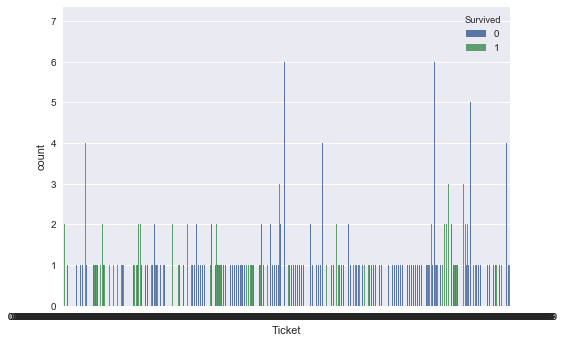

In [8]:
# 同樣的，重要性第二名的特徵是船票，屬於類別特徵，以迴歸圖無法看出適當的關係
# 然而船票種類過多，以計數圖（Countplot）也沒辦法明確看出結果
# 第二名       
# sns.regplot(x=train_Y, y=df[feats.index[1]], fit_reg=False)
data = pd.concat([df, train_Y], axis = 1)
sns.countplot('Ticket', hue = 'Survived', data = data)
plt.show()

In [9]:
# 製作新特徵看效果
df['add_char'] = (df['Sex'] + df['Ticket']) / 2
df['multi_char'] = (df['Sex'] * df['Ticket'])
df['div_1_2'] = (df['Sex'] / (df['Ticket'] + 1)) * 2
df['div_2_1'] = (df['Ticket'] / (df['Sex'] + 1)) * 2
train_X = MMEncoder.fit_transform(df)
print(f'shape: {train_X.shape}')
print(f'score: {cross_val_score(estimator, train_X, train_Y, cv = 5).mean()}')

shape: (891, 14)
score: 0.8282907538760906
